Before discussing multiclass logistic regression, we will briefly mention logistic regression. Logistic regression is a binary classification technique that uses logistic function ($\frac{1}{1+e^{-x}}$) to fit data. Contrary to linear regression where the output is a numerical value, in logistic regression the output is a probability scores of an input belonging to a particular class. 

If there are $p$ predictors (also known as independent variables) $X_1, X_2, \ldots, X_p$, in linear regression, the target (dependent variable) $y$ takes the form
$$ y = \beta_0 +\beta_1X_1 + \beta_2X_2 + \ldots \beta_pX_p$$

In logistic regression, the target is either 0 (for one class) or 1 (for other class) and $p(x)$ denotes the probability that a point belongs to a particular class. If the probability score exceeds a threshold, it is assigned to one class or other. In logistic regression log odds is modeled as a linear combination of predictors
$$log\big(\frac{p(x)}{1-p(x)}\big) = \beta_0 +\beta_1X_1 + \beta_2X_2 + \ldots \beta_pX_p$$

After simplification, the above equation will take the form
$$p(x) = \frac{1}{1+e^{-(\beta_0 +\beta_1X_1 + \beta_2X_2 + \ldots \beta_pX_p)}}$$ 
Now the task is to learn the parameters $\beta_0, \beta_1, \ldots \beta_p$. This is done by minimizing the negative log-likelihood with respect to training data. Minimizing negative log-likelihood is equivalent to maximizing likelihood. 

One point to note here is that, unlike linear regression where a closed form solution exists, logistic regression solution may not converge sometimes. This happens if the classes are well separated from each other. We will not discuss this point further here, rather we will refer the readers to [this excellent short article](https://www.nature.com/articles/nmeth.3904).

As mentioned previously, logistic regression can handle only two classes. For multiclass classification problems there are extensions of logistic regression. One simple strategy is to do one-vs-all classification. This converts multiclass classification problem involving $k$ classes into $k$ binary classification problem. In each of those $k$ binary classification problems, one class is compared against rest all of the classes. For prediction, a point is assigned to a class for which its probability score is maximum.

We will not implement these on our own. Rather we will use R. The beauty of R is that most of the statistical techniques are already implemented in it so that we can just use those for our analysis. In our case we will use 'nnet' package to implement multiclass logistic regression algorithm involving 10 classes. 

## Description of data

[Detailed discussion of how to prepare the data and its source can be found in this post.](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/SVM_wavelet_energy_multiclass_cwru_python.ipynb) Here we will only mention about different classes of the data. There are 10 classes and data for each class are taken at a load of 1hp. The classes are:

* C1  : Ball defect (0.007 inch)
* C2  : Ball defect (0.014 inch)
* C3  : Ball defect (0.021 inch)
* C4  : Inner race fault (0.007 inch)
* C5  : Inner race fault (0.014 inch)
* C6  : Inner race fault (0.021 inch)
* C7  : Normal
* C8  : Outer race fault (0.007 inch, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, 6 O'clock)
* C10 : Outer race fault (0.021 inch, 6 O'clock)

**Important Note:** In the CWRU website, sampling frequency for the normal data is not mentioned. Most research paper take it as 48k. Some authors also consider it as being taken at a sampling frequency of 12k. Some other authors just use it without ever mentioning its sampling frequency. In our application we only need segment of normal data of length 1024. So we will use the normal data segments available at the website without going into the discussion of sampling frequency. Still, to be on the safer side, we will show results including the normal data as a class as well as excluding it.

When we exclude normal data, we won't consider "C9" class and study the rest 11 fault classes. At that time "C09", "C10", and "C11" will correspond to outer race faults of fault depth 0.007, 0.014, and 0.021 inch respectively.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

### How to get data?

Readers can download the `.csv` file used in this notebook from [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/feature_wav_energy8_12k_1024_load_1.csv). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

In [2]:
data_wav_energy = pd.read_csv("./data/feature_wav_energy8_12k_1024_load_1.csv")

In [3]:
data_wav_energy['fault'] = pd.Categorical(data_wav_energy['fault'])

In [4]:
train_wav_energy, test_wav_energy = train_test_split(data_wav_energy, test_size = 420, stratify = data_wav_energy['fault'],
                                                    random_state = 324)

In [5]:
scaler = StandardScaler()
train_wav_energy_scaled = scaler.fit_transform(train_wav_energy.iloc[:,:-1])
test_wav_energy_scaled = (test_wav_energy.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)

In [6]:
logistic_clf = LogisticRegression(C = 500, max_iter = 200, n_jobs = -1)

In [7]:
logistic_clf.fit(train_wav_energy_scaled, train_wav_energy['fault'])

LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
train_predictions = logistic_clf.predict(train_wav_energy_scaled)
test_predictions = logistic_clf.predict(test_wav_energy_scaled)

In [9]:
train_confu_matrix = confusion_matrix(train_wav_energy['fault'], train_predictions)
test_confu_matrix = confusion_matrix(test_wav_energy['fault'], test_predictions)

In [10]:
train_accuracy = accuracy_score(train_wav_energy['fault'], train_predictions)
print("Ovearll training accuracy: ", train_accuracy)

Ovearll training accuracy:  1.0


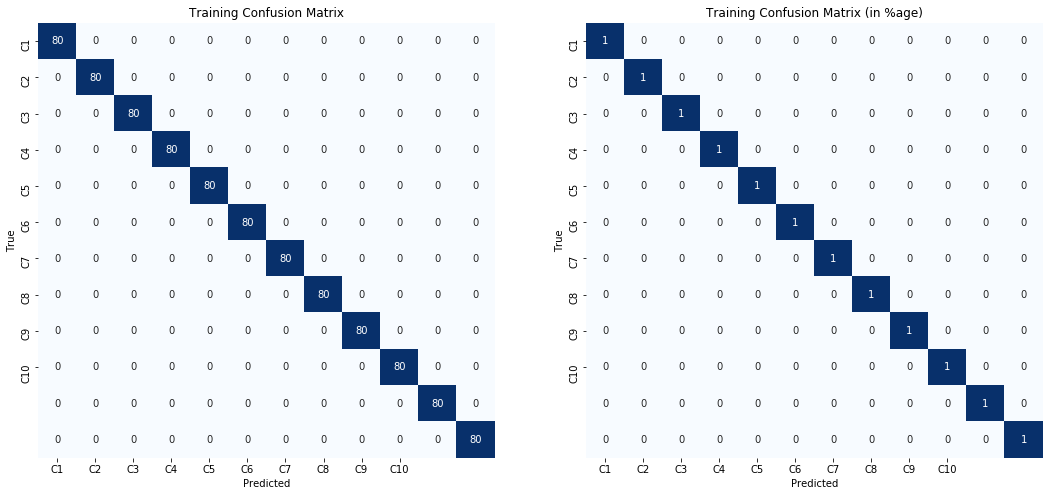

In [11]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/80, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

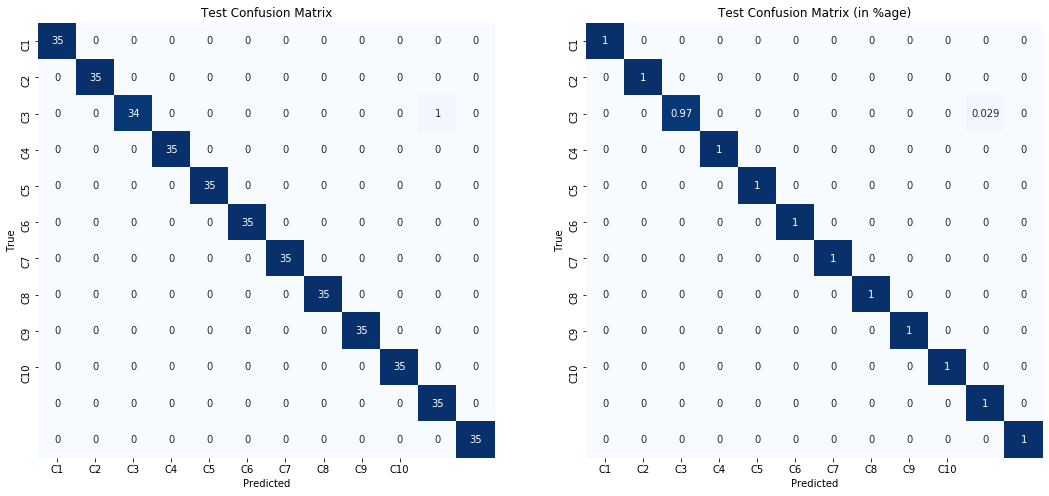

In [12]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/35, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
overall_test_accuracy = accuracy_score(test_wav_energy['fault'], test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  0.9976190476190476


We will also show the results excluding the normal data. The results are as below.

In [14]:
data_without_normal = pd.read_csv("./data/feature_wav_energy8_12k_1024_load_1.csv", nrows = 1265)

In [15]:
data_without_normal['fault'].value_counts()

OR_014_6_1    115
OR_007_6_1    115
OR_021_6_1    115
IR_007_1      115
IR_028_1      115
Ball_021_1    115
Ball_014_1    115
IR_021_1      115
Ball_028_1    115
Ball_007_1    115
IR_014_1      115
Name: fault, dtype: int64

In [16]:
train_data_new, test_data_new = train_test_split(data_without_normal, test_size = 385, stratify = data_without_normal['fault'],
                                                random_state = 8928)

In [17]:
new_scaler = StandardScaler()
train_data_scaled_new = new_scaler.fit_transform(train_data_new.iloc[:,:-1])
test_data_scaled_new = (test_data_new.iloc[:,:-1].values - new_scaler.mean_)/np.sqrt(new_scaler.var_)

In [18]:
logistic_clf_new = LogisticRegression(C = 2000, max_iter = 200, n_jobs = -1)

In [19]:
logistic_clf_new.fit(train_data_scaled_new, train_data_new['fault'])

LogisticRegression(C=2000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
train_predictions_new = logistic_clf_new.predict(train_data_scaled_new)
test_predictions_new = logistic_clf_new.predict(test_data_scaled_new)

In [21]:
train_confu_matrix_new = confusion_matrix(train_data_new['fault'], train_predictions_new)
test_confu_matrix_new = confusion_matrix(test_data_new['fault'], test_predictions_new)

In [22]:
train_accuracy_new = accuracy_score(train_data_new['fault'], train_predictions_new)
print("Ovearll training accuracy (excluding normal data): ", train_accuracy_new)

Ovearll training accuracy (excluding normal data):  1.0


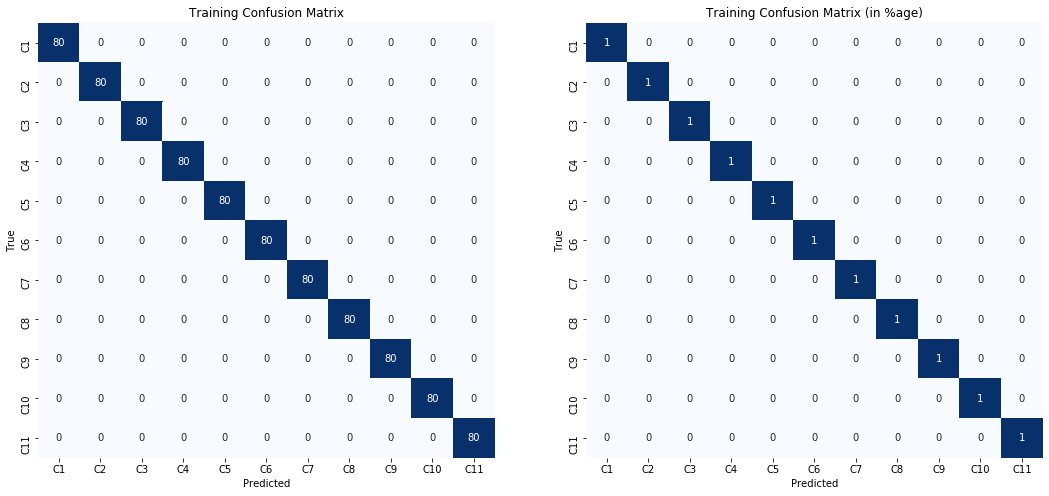

In [23]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix_new, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix_new/80, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

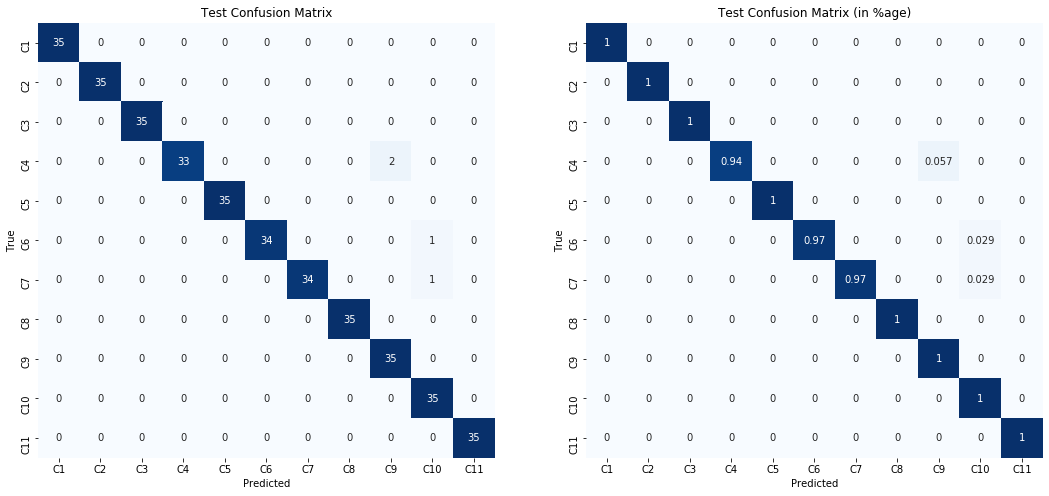

In [24]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix_new, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix_new/35, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
overall_test_accuracy_new = accuracy_score(test_data_new['fault'], test_predictions_new)
print("Overall test accuracy (excluding normal data): ", overall_test_accuracy_new)

Overall test accuracy (excluding normal data):  0.9896103896103896


[To see results of other techniques applied to public condition monitoring datasets, visit this page](https://biswajitsahoo1111.github.io/cbm_codes_open/).